In [1]:
import csv
import matplotlib.pyplot as plt
from matplotlib import transforms
import numpy as np
import copy

In [2]:
DATASET_TYPES = ["AAVE_UK", "RAVDESS", "Accents", "Nigeria_UK_Midlands"]
DATASET_TYPE_VAL = 1

SAVE_ONLY_TOTAL = False
COMPREHENSIBILITY_THRESHOLD_IN_TITLE = True

DATASET_TYPE = DATASET_TYPES[DATASET_TYPE_VAL]

ASR_TYPES = ["MS_IBM", "GCP_IBM", "MS_GCP"]

TRANSFORMATION_TYPES = ["Amp", "Clipping", "Drop", "Frame", "HP", "LP", "Noise", "Scale"]

GROUPS = ['Male', 'Female']

GET_UNIQUE_ERRORS = False

# SAVE_FOLDER = "/Users/sakshiudeshi/Documents/SUTD/Research/LaTeX/speechPaper/figs/"
# SAVE_FOLDER = "/Users/sakshiudeshi/Documents/SUTD/Research/LaTeX/speechPaper/figs/RQ2/"

COMPREHENSIBILITY_THRESHOLD = 6
SAVE_FOLDER = "Saved_Imgs/"

In [3]:
USER_STUDY_AVERAGES = {
    "Amp": [8.020304569, 7.634517766, 7.492385787, 7.558375635, 7.497461929, 7.182741117],
    "Clipping": [7.421319797, 7.162436548, 7.335025381, 6.92893401, 6.974619289],
    "Drop": [7.903553299, 7.431472081, 7.456852792, 7.223350254, 7.07106599],
    "Frame": [7.45177665, 7.416243655, 7.507614213, 7.507614213, 7.375634518], 
    "HP": [7.756345178, 7.553299492, 7.401015228, 7.324873096, 7.411167513], 
    "LP": [7.340101523, 7.182741117, 7.065989848, 7.131979695, 7.025380711], 
    "Noise": [7.223350254, 7.045685279, 7.025380711, 6.989847716, 6.837563452], 
    "Scale": [7.781725888, 7.335025381, 7.203045685]
}

In [4]:
def get_plot_title(DATASET_TYPE):
    if (DATASET_TYPE == "AAVE_UK"):
        return "AAVE/UK Midlands English"
    elif (DATASET_TYPE == "Nigeria_UK_Midlands"):
        return "Nigerian English/UK Midlands English"
    else: return DATASET_TYPE

In [5]:
def get_groups(dataset_type = DATASET_TYPE):
    if dataset_type == DATASET_TYPES[0]:
        return ['AAVE', 'UK Midlands English']
    
    elif dataset_type == DATASET_TYPES[1]:
        return ['Male', 'Female']
    
    if dataset_type == DATASET_TYPES[3]:
        return ['UK Midlands English', 'Nigerian English']
    
    else:
        return ['English', 'Ganda', 'French', 'Gujarati', 'Indonesian' ,'Korean', 'Russian']
    
GROUPS = get_groups()
print(GROUPS)

['Male', 'Female']


In [6]:
def get_filename_filler(dataset_type = DATASET_TYPE):
    if dataset_type == "Accents":
        return " Differential Speech Results - "
    elif dataset_type == "Nigeria_UK_Midlands":
        return " Nigeria_UK Midlands - "
    else: 
        return " - " 

In [7]:
def get_file_data(asr_type, transformation_type):
    file_name = DATASET_TYPE + "/" + asr_type + "/" + asr_type + \
    get_filename_filler() + transformation_type + ".csv"
    with open(file_name, newline='') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        file_arr = list(reader)
    return file_arr, transformation_type, asr_type

In [8]:
def get_diff_rows_range(transformation_type = TRANSFORMATION_TYPES[0], 
                        threshold = COMPREHENSIBILITY_THRESHOLD):
    rows_range = []
    if (transformation_type == "Amp"):
        base = 12
    else:
        base = 11
    for i, val in enumerate(USER_STUDY_AVERAGES[transformation_type]):
        if val > threshold:
            rows_range.append(i + base)
    return rows_range

# get_diff_rows_range("HP", threshold = 7.4)

In [9]:
def process_num_arr(num_arr):
    tag = str(num_arr[0])
    num_arr = num_arr[1:len(num_arr)]
    return [float(i) for i in num_arr], tag

In [10]:
def get_relevant_rows(file_data, transformation_type = TRANSFORMATION_TYPES[0]):
    diff_rows = get_diff_rows_range(transformation_type)
    row_arr, tag_arr = [], []
    for i in diff_rows:
        row, tag = process_num_arr(file_data[i - 1])
        row_arr.append(row)
        tag_arr.append(tag)
    return row_arr, tag_arr

In [11]:
def get_formatted_diff_data(asr_type, transformation_type):
    file, _ , _  = get_file_data(asr_type = asr_type, transformation_type = transformation_type)
#     row_arr, tag_arr = get_relevant_rows(file_data = file, transformation_type = trans_type)
    row_arr, tag_arr = get_relevant_rows(file_data = file, transformation_type = transformation_type)
#     for i, row in enumerate(row_arr):
#         print(tag_arr[i], row)
#     print()
    return row_arr, tag_arr

In [12]:
def get_top_threshold(threshold):
#     [0.01, 0.05, 0.1, 0.15]
    if (threshold == 0.01):
        return 0.05
    elif (threshold == 0.05):
        return 0.1
    elif (threshold == 0.1):
        return 0.15
    elif (threshold == 0.15):
        return 1
    else:
        return 1

In [13]:
def get_diffs_data(asr_type, transformation_type, languages = GROUPS, 
                   get_unique_errors = GET_UNIQUE_ERRORS):
    row_arr, tag_arr = get_formatted_diff_data(asr_type, transformation_type)
    
    row_diff_arr = []
    
    if (not get_unique_errors):
        top_threshold = 1.1
    else:
        top_threshold = get_top_threshold(threshold)
    
    for row in row_arr:
        diff_arr = []
        for base_gr in range(len(row)):
            errors = 0
            for comp_gr in range(len(row)):
                diff = row[base_gr] - row[comp_gr]
                diff_arr.append(diff)
        row_diff_arr.extend(diff_arr)
            
    return row_diff_arr, tag_arr
            
            
        

In [14]:
class error_data_nugget:
    def __init__(self, asr_type, transformation_type, diff_arr):
        self.asr_type = asr_type
        self.transformation_type = transformation_type
        self.diff_arr = diff_arr

In [15]:
error_data_nuggets = []

for asr_type in ASR_TYPES:
    sum_rows = []
    for trans_type in TRANSFORMATION_TYPES:
        row_diff_arr, tag_arr = get_diffs_data(asr_type, trans_type)
        error_data_nuggets.append(error_data_nugget(asr_type, trans_type, row_diff_arr))  


In [16]:
def get_asr_type_data_subset(error_data_nuggets, asr_type = "MS_IBM"):
    error_data_nuggets_subsets = []
    for data in error_data_nuggets:
        if data.asr_type == asr_type:
            error_data_nuggets_subsets.append(data)
    return error_data_nuggets_subsets

In [17]:
def get_asr_gr_type_subset(error_data_nuggets, gr_val = 0):
    error_data_nuggets_subsets = []
    for data in error_data_nuggets:
        error_data_nuggets_subsets.append(error_data_nugget(data.tau, data.asr_type, 'ALL', [data.error_sum_row[gr_val]]))
    return error_data_nuggets_subsets

In [18]:
def get_asr_tr_type_subset(error_data_nuggets, tr_type = "Noise"):
    error_data_nuggets_subsets = []
    
    for data in error_data_nuggets:
        if data.transformation_type == tr_type:
            error_data_nuggets_subsets.append(data)    
    return error_data_nuggets_subsets

In [19]:
def get_single_arr_dist(error_data_nuggets, thresh = -100000):
    single_arr_dist = []
    for error_data_nugget in error_data_nuggets:
#         print(error_data_nugget.asr_type, error_data_nugget.transformation_type, error_data_nugget.diff_arr)
        single_arr_dist.extend(error_data_nugget.diff_arr)
    return [i for i in single_arr_dist if i > thresh]

In [20]:
# # for error_data_nugget in error_data_nuggets:
# #     print(error_data_nugget.asr_type, error_data_nugget.transformation_type, error_data_nugget.diff_arr)
# print(get_single_arr_dist(error_data_nuggets))

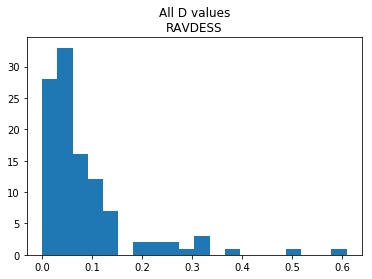

In [21]:
n_bins = 20
plt.hist(get_single_arr_dist(error_data_nuggets, thresh=0), bins=n_bins)
plt.title("All D values\n" + get_plot_title(DATASET_TYPE))
# plt.xticks(arange(len(AlphaNum)),AlphaNum)
plt.show()

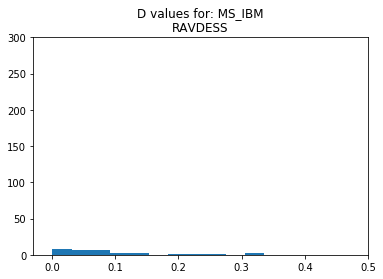

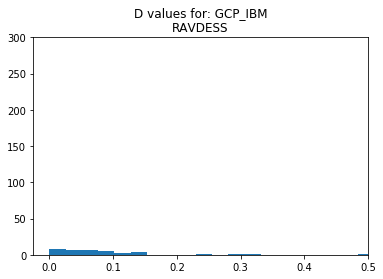

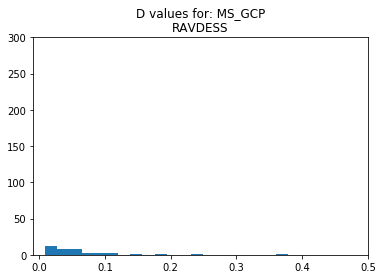

In [22]:
n_bins = 20
for i, asr_type in enumerate(ASR_TYPES):
    error_data_nuggets_subset = get_asr_type_data_subset(error_data_nuggets, asr_type = asr_type)
    plt.hist(get_single_arr_dist(error_data_nuggets_subset, thresh=0), bins=n_bins)
    plt.title("D values for: " + asr_type + "\n" + get_plot_title(DATASET_TYPE))
    plt.ylim(top=300)
    plt.xlim(right=0.5)
    plt.show()

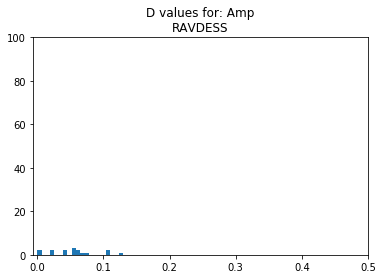

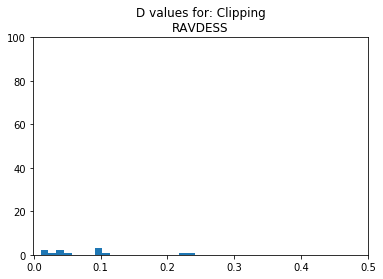

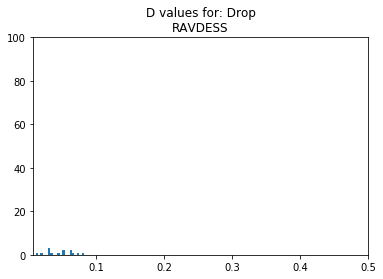

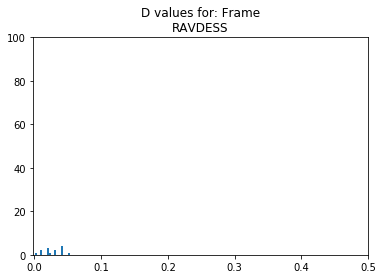

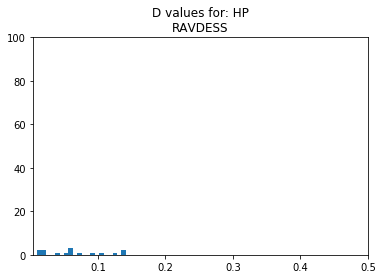

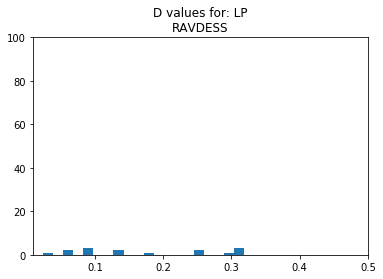

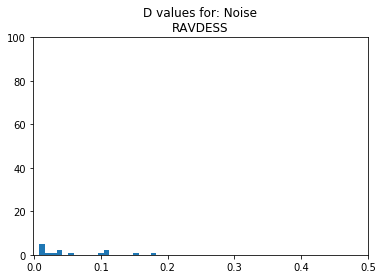

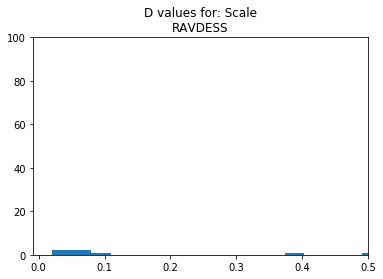

In [23]:
n_bins = 20
for i, trans_type in enumerate(TRANSFORMATION_TYPES):
    error_data_nuggets_subset = get_asr_tr_type_subset(error_data_nuggets, tr_type = trans_type)
    plt.hist(get_single_arr_dist(error_data_nuggets_subset, thresh=0), bins=n_bins)
    plt.title("D values for: " + trans_type + "\n" + get_plot_title(DATASET_TYPE))
    plt.ylim(top=100)
    plt.xlim(right=0.5)

    plt.show()